In [1]:
!pip install jupyter pandas pymongo dnspython matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


### Load Dataset in Jupyter Notebook

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("data.csv", encoding='ISO-8859-1')

# Display the first few rows
df.head()

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Check Dataset Information

In [3]:
# Check dataset structure
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data Cleaning & Preprocessing

In [4]:
# Remove missing CustomerIDs
df_cleaned = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Remove negative Quantity and UnitPrice
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

# Display cleaned data
df_cleaned.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\574001352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Connect to MongoDB

In [6]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Create database and collection
db = client["ecommerce_db"]
collection = db["transactions"]

### Insert Data into MongoDB

In [7]:
# Insert data into MongoDB
data_dict = df_cleaned.to_dict(orient="records")
collection.insert_many(data_dict)

print("Data inserted into MongoDB successfully!")

Data inserted into MongoDB successfully!


### Retrieve One Record

In [8]:
print(collection.find_one())

{'_id': ObjectId('67bc5a78b973dd008e99f134'), 'InvoiceNo': '536365', 'StockCode': '85123A', 'Description': 'WHITE HANGING HEART T-LIGHT HOLDER', 'Quantity': 6, 'InvoiceDate': datetime.datetime(2010, 12, 1, 8, 26), 'UnitPrice': 2.55, 'CustomerID': 17850.0, 'Country': 'United Kingdom'}


### Count Total Records

In [9]:
print(f"Total records in MongoDB: {collection.count_documents({})}")

Total records in MongoDB: 397884


### Top Selling Products

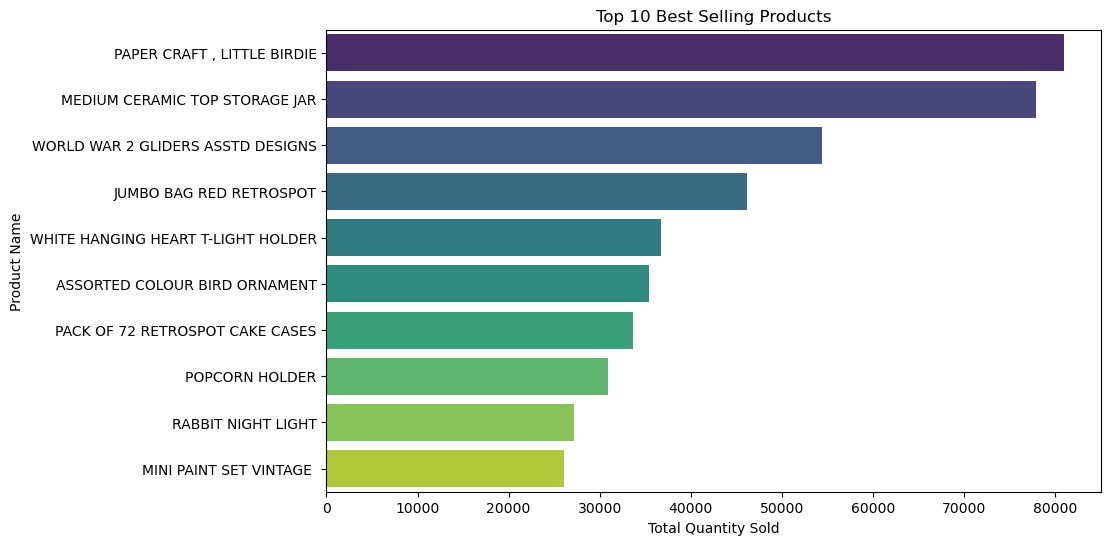

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate top 10 products by sales volume
top_products = collection.aggregate([
    {"$group": {"_id": "$Description", "total_sales": {"$sum": "$Quantity"}}},
    {"$sort": {"total_sales": -1}},
    {"$limit": 10}
])

# Convert to DataFrame
top_products_df = pd.DataFrame(list(top_products))

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=top_products_df, x="total_sales", y="_id", palette="viridis")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Name")
plt.title("Top 10 Best Selling Products")
plt.show()

### Monthly Sales Trend

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


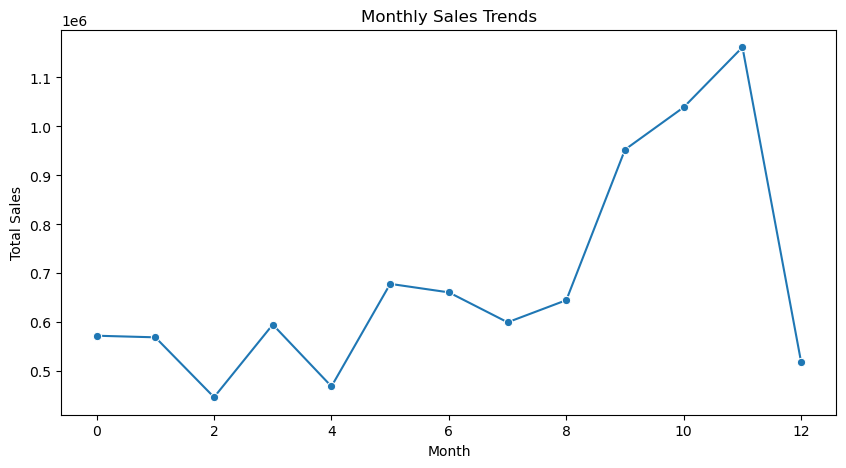

In [11]:
# Monthly sales trend
monthly_sales = collection.aggregate([
    {"$group": {"_id": {"year": {"$year": "$InvoiceDate"}, "month": {"$month": "$InvoiceDate"}}, 
                "total_sales": {"$sum": {"$multiply": ["$Quantity", "$UnitPrice"]}}}},
    {"$sort": {"_id": 1}}
])

# Convert to DataFrame
monthly_sales_df = pd.DataFrame(list(monthly_sales))

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_sales_df.index, y="total_sales", data=monthly_sales_df, marker="o")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trends")
plt.show()

### Customer Segmentation - Top 10 Customers by Revenue

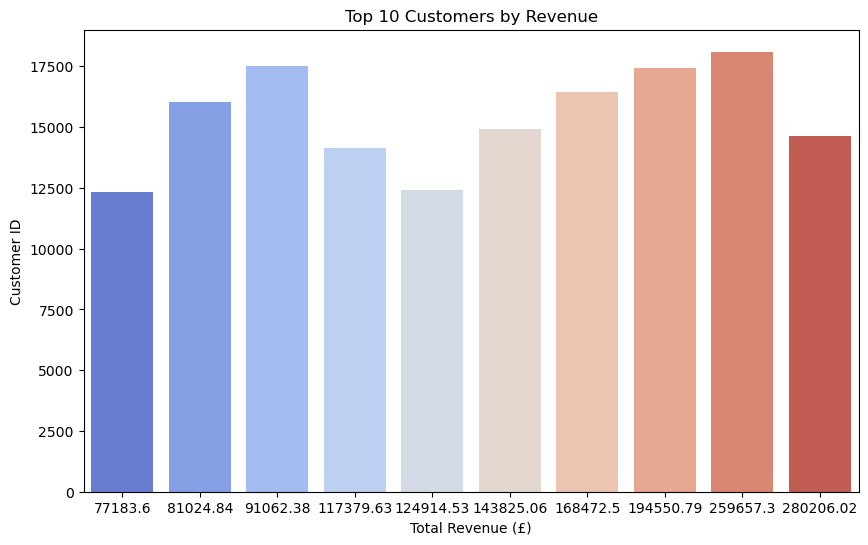

In [12]:
# Aggregate top 10 customers by total revenue
top_customers = collection.aggregate([
    {"$group": {"_id": "$CustomerID", "total_revenue": {"$sum": {"$multiply": ["$Quantity", "$UnitPrice"]}}}},
    {"$sort": {"total_revenue": -1}},
    {"$limit": 10}
])

# Convert to DataFrame
top_customers_df = pd.DataFrame(list(top_customers))

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=top_customers_df, x="total_revenue", y="_id", palette="coolwarm")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Customer ID")
plt.title("Top 10 Customers by Revenue")
plt.show()
